In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchmetrics import ConfusionMatrix
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import numpy as np

## Lets get the data, model and setup trainnig code

In [3]:
train_loader = DataLoader(datasets.MNIST("./", train=True, transform=transforms.ToTensor(), download=True), batch_size=128, shuffle=True)
test_loader = DataLoader(datasets.MNIST("./", train=False, transform=transforms.ToTensor(), download=True), batch_size=128, shuffle=False)

print(f"Training images {len(train_loader.dataset)}, Test images {len(test_loader.dataset)}")

Training images 60000, Test images 10000


In [4]:
class mnist_model(nn.Module):
  def __init__(self):
    super(mnist_model, self).__init__()
    self.layer1 = nn.Conv2d(1, 20, kernel_size=5, stride=1, padding=0)
    self.layer2 = nn.Conv2d(20, 50, kernel_size=5, stride=1, padding=0)
    self.layer3 = nn.Linear(800, 500, bias=True)
    self.layer4 = nn.Linear(500, 10, bias=True)

    self.act = nn.ReLU()
    self.pool = nn.MaxPool2d((2, 2))

  def forward(self, x):
    out = self.act(self.layer1(x))
    out = self.pool(out)
    out = self.act(self.layer2(out))
    out = self.pool(out)
    out = out.view(-1, 800)
    out = self.act(self.layer3(out))
    out = self.act(self.layer4(out))
    return out

  def output(self, x):
    out1 = self.act(self.layer1(x))
    out1 = self.pool(out1)
    out2 = self.act(self.layer2(out1))
    out2 = self.pool(out2)
    out2 = out2.view(-1, 800)
    out3 = self.act(self.layer3(out2))
    out4 = self.act(self.layer4(out3))    
    return out1, out2, out3, out4

In [5]:
model = mnist_model().cuda()
print(model)

epochs = 15
lr = 0.1

optimizer = optim.SGD(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()
lrs = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, epochs)

mnist_model(
  (layer1): Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1))
  (layer2): Conv2d(20, 50, kernel_size=(5, 5), stride=(1, 1))
  (layer3): Linear(in_features=800, out_features=500, bias=True)
  (layer4): Linear(in_features=500, out_features=10, bias=True)
  (act): ReLU()
  (pool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
)




```
# This is formatted as code
```

## Training

In [6]:
def get_acc(model, loader):
  correct = 0
  total = 0
  for img, label in loader:
    correct += torch.sum(torch.argmax(model(img.cuda()), -1).cpu() == label).item()
    total += len(img)
  return 100*correct/total

In [7]:
for e in range(epochs):
  print("lr", optimizer.param_groups[0]["lr"])
  for img, label in train_loader:
    # print(img.shape, label.shape)
    out = model(img.cuda())
    # print(out.shape)
    optimizer.zero_grad()
    loss = criterion(out, label.cuda())
    loss.backward()
    optimizer.step()
  lrs.step()
  print(f"Epoch {e}, training accuracy {get_acc(model, train_loader)}, test accuracy {get_acc(model, test_loader)}")

lr 0.1
Epoch 0, training accuracy 68.39, test accuracy 67.79
lr 0.09890738003669029
Epoch 1, training accuracy 78.50666666666666, test accuracy 78.15
lr 0.09567727288213004
Epoch 2, training accuracy 78.895, test accuracy 78.75
lr 0.09045084971874738
Epoch 3, training accuracy 88.63666666666667, test accuracy 88.3
lr 0.08345653031794292
Epoch 4, training accuracy 98.735, test accuracy 98.45
lr 0.07500000000000001
Epoch 5, training accuracy 99.14, test accuracy 98.86
lr 0.06545084971874739
Epoch 6, training accuracy 99.16166666666666, test accuracy 98.85
lr 0.05522642316338269
Epoch 7, training accuracy 99.30666666666667, test accuracy 98.82
lr 0.04477357683661735
Epoch 8, training accuracy 99.45833333333333, test accuracy 98.99
lr 0.03454915028125265
Epoch 9, training accuracy 99.535, test accuracy 99.07
lr 0.02500000000000002
Epoch 10, training accuracy 99.60333333333334, test accuracy 99.05
lr 0.01654346968205711
Epoch 11, training accuracy 99.64666666666666, test accuracy 99.07
lr 0

## Extract weights

In [8]:
params = [(name, p.data.cpu().numpy()) for (name, p) in model.named_parameters()]

In [8]:
for (name, p) in params:
  print(f"Layer {name.split('.')[0]}, type {name.split('.')[1]}, shape {p.shape}")

Layer layer1, type weight, shape (20, 1, 5, 5)
Layer layer1, type bias, shape (20,)
Layer layer2, type weight, shape (50, 20, 5, 5)
Layer layer2, type bias, shape (50,)
Layer layer3, type weight, shape (500, 800)
Layer layer3, type bias, shape (500,)
Layer layer4, type weight, shape (10, 500)
Layer layer4, type bias, shape (10,)


In [9]:
#print(params)

## Visualize hidden activations

In [10]:
print(model.children())
out = list(model.children())[0](img.cuda()).data.cpu().numpy()

<generator object Module.children at 0x7f4becba2d50>


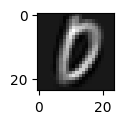

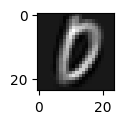

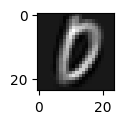

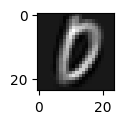

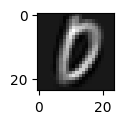

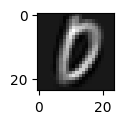

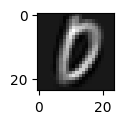

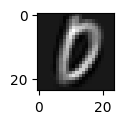

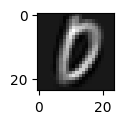

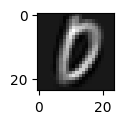

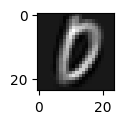

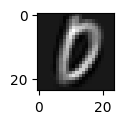

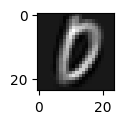

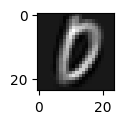

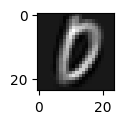

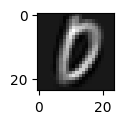

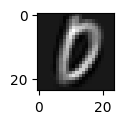

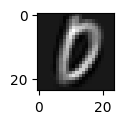

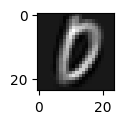

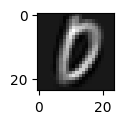

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline

for _ in range(out.shape[1]):
  plt.figure(figsize=(1, 1))
  plt.imshow(out[0, 0], cmap="gray")

In [9]:
for img, label in train_loader:
  break

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
path = "/content/drive/My Drive/Colab Notebooks/Falcon Neural Network/LeNet/"

In [18]:
import os

path = "./preload/LeNet/"
np.savetxt(fname=path+"input_0", delimiter=" ", X=img.cuda().view(-1, 784).tolist())
np.savetxt(fname=path+"outputlayer1_0", delimiter=" ", X=model.output(img.cuda().view(128, 1, 28, 28))[0].data.cpu().view(-1))
np.savetxt(fname=path+"outputlayer2_0", delimiter=" ", X=model.output(img.cuda().view(128, 1, 28, 28))[1].tolist())
np.savetxt(fname=path+"outputlayer3_0", delimiter=" ", X=model.output(img.cuda().view(128, 1, 28, 28))[2].tolist())
np.savetxt(fname=path+"outputlayer4_0", delimiter=" ", X=model.output(img.cuda().view(128, 1, 28, 28))[3].tolist())

np.savetxt(fname=path+"weight1_0", delimiter=" ", X=params[0][1].reshape(5*5*1, 20).tolist())
np.savetxt(fname=path+"bias1_0", delimiter=" ", X=params[1][1].tolist())
np.savetxt(fname=path+"weight2_0", delimiter=" ", X=params[2][1].reshape(5*5*20, 50).tolist())
np.savetxt(fname=path+"bias2_0", delimiter=" ", X=params[3][1].tolist())
np.savetxt(fname=path+"weight3_0", delimiter=" ", X=params[4][1].tolist())
np.savetxt(fname=path+"bias3_0", delimiter=" ", X=params[5][1].tolist())
np.savetxt(fname=path+"weight4_0", delimiter=" ", X=params[6][1].tolist())
np.savetxt(fname=path+"bias4_0", delimiter=" ", X=params[7][1].tolist())

In [11]:
# Do some run on the network
first = True
act = []
prd = []
for (img, labels) in test_loader:
    # Get the prediction
    res = model(img.cuda())

    # Get the label
    label = np.array([[1 if i == l else 0 for i in range(10)] for l in labels])

    # Write the batch
    if first:
        mode = "w"
        first = False
    else:
        mode = "a"
    with open("./results/LeNet_gold.txt", mode) as h:
        np.savetxt(h, delimiter=" ", X=label.tolist())
    with open("./results/LeNet_pred.txt", mode) as h:
        np.savetxt(h, delimiter=" ", X=res.tolist())

    # Add the class numbers
    act += labels
    prd += [ np.argmax(out.cpu().detach().numpy()) for out in res ]

# Compute the things
confmat = ConfusionMatrix(task="multiclass", num_classes=10)
confmat(torch.tensor(prd), torch.tensor(act))

tensor([[ 975,    0,    0,    0,    0,    0,    1,    2,    2,    0],
        [   0, 1133,    0,    0,    0,    0,    1,    1,    0,    0],
        [   1,    1, 1024,    0,    2,    0,    0,    2,    2,    0],
        [   0,    0,    1, 1004,    0,    2,    0,    1,    1,    1],
        [   1,    0,    1,    0,  972,    0,    1,    2,    0,    5],
        [   2,    0,    0,    7,    0,  879,    1,    1,    1,    1],
        [   4,    2,    0,    1,    1,    2,  946,    0,    2,    0],
        [   0,    3,    3,    1,    0,    0,    0, 1018,    1,    2],
        [   2,    0,    1,    2,    0,    2,    0,    2,  963,    2],
        [   0,    2,    0,    1,    4,    2,    0,    3,    0,  997]])